# CALIPSO HDF to COPC.LAZ Conversion Pipeline

This notebook provides a complete pipeline for converting CALIPSO Level 1 HDF files to Cloud-Optimized Point Cloud (COPC) format with comprehensive verification.

## Pipeline Overview
```
HDF4 → LAS 1.4 → COPC.LAZ
```

## What This Notebook Does
1. **Convert HDF to LAS** - Using existing `calipso_to_las.py` functions
2. **Convert LAS to COPC** - Using PDAL pipeline
3. **Visualize Before/After** - Side-by-side comparisons
4. **Verify Data Integrity** - Comprehensive statistical checks
5. **Assess Quality** - Compression, precision, and correctness metrics

## Output Directory Structure
```
data/
├── raw/                  # Original HDF files
├── converted_las/        # Intermediate LAS files
└── final/                # Final COPC.LAZ files
```

---
## Section 1: Setup & Configuration

In [1]:
# Import standard libraries
import sys
import subprocess
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import warnings

# Point cloud libraries
import laspy
print(f"laspy version: {laspy.__version__}")

from pyhdf.SD import SD, SDC

# Optional visualization libraries
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Configure plotting
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10


laspy version: 2.5.4


In [2]:
# Import conversion functions from calipso_to_las.py
sys.path.insert(0, str(Path.cwd()))

from calipso_to_las import (
    get_calipso_altitudes,
    read_calipso_hdf,
    create_point_cloud,
    write_las,
    convert_calipso_to_las
)


In [3]:
# Configure paths
DATA_DIR = Path('.')
RAW_DIR = DATA_DIR / 'raw'
LAS_DIR = DATA_DIR / 'converted_las'
COPC_DIR = DATA_DIR / 'final'

# Create output directories if they don't exist
LAS_DIR.mkdir(exist_ok=True)
COPC_DIR.mkdir(exist_ok=True)

# PDAL configuration
PDAL_BIN = '/opt/anaconda3/envs/pdal/bin/pdal'
PDAL_PIPELINE = DATA_DIR / 'las_to_copc_fixed.json'

# Check if PDAL is available
try:
    result = subprocess.run([PDAL_BIN, '--version'], capture_output=True, text=True)
    print(f"PDAL available: {result.stdout.strip()}")
except FileNotFoundError:
    print(f"PDAL not found at {PDAL_BIN}")
    print("Install with: conda create -n pdal -c conda-forge pdal python-pdal")

# Check if pipeline configuration exists
if PDAL_PIPELINE.exists():
    print(f"PDAL pipeline found: {PDAL_PIPELINE.name}")
else:
    print(f"PDAL pipeline not found: {PDAL_PIPELINE}")


PDAL available: --------------------------------------------------------------------------------
pdal 2.8.4 (git-version: Release)
--------------------------------------------------------------------------------
PDAL pipeline found: las_to_copc_fixed.json


In [4]:
# List available HDF files
import glob

hdf_files = sorted(glob.glob(str(RAW_DIR / '*.hdf')))

print(f"Found {len(hdf_files)} CALIPSO HDF files:\n")
for i, filepath in enumerate(hdf_files):
    filename = Path(filepath).name
    file_size_mb = Path(filepath).stat().st_size / (1024**2)
    print(f"[{i}] {filename}")
    print(f"    Size: {file_size_mb:.1f} MB\n")

print("="*80)

Found 7 CALIPSO HDF files:

[0] CAL_LID_L1-Standard-V4-51.2023-06-30T16-44-43ZD.hdf
    Size: 488.6 MB

[1] CAL_LID_L1-Standard-V4-51.2023-06-30T17-37-28ZN.hdf
    Size: 425.1 MB

[2] CAL_LID_L1-Standard-V4-51.2023-06-30T18-23-08ZD.hdf
    Size: 488.6 MB

[3] CAL_LID_L1-Standard-V4-51.2023-06-30T19-15-53ZN.hdf
    Size: 425.1 MB

[4] CAL_LID_L1-Standard-V4-51.2023-06-30T20-01-33ZD.hdf
    Size: 488.6 MB

[5] CAL_LID_L1-Standard-V4-51.2023-06-30T20-54-18ZN.hdf
    Size: 424.7 MB

[6] CAL_LID_L1-Standard-V4-51.2023-06-30T21-39-53ZD.hdf
    Size: 489.0 MB



In [5]:
# SELECT FILE TO CONVERT
# Change this index to process different files
FILE_INDEX = 0 

# Get file paths
hdf_path = Path(hdf_files[FILE_INDEX])
hdf_filename = hdf_path.stem  # Filename without extension

# Define output paths
las_path = LAS_DIR / f"{hdf_filename}.las"
copc_path = COPC_DIR / f"{hdf_filename}.copc.laz"

print(f"Selected file for conversion:")
print(f"   HDF:  {hdf_path.name}")
print(f"   LAS:  {las_path.name}")
print(f"   COPC: {copc_path.name}")
print(f"\nInput file size: {hdf_path.stat().st_size / (1024**2):.1f} MB")

Selected file for conversion:
   HDF:  CAL_LID_L1-Standard-V4-51.2023-06-30T16-44-43ZD.hdf
   LAS:  CAL_LID_L1-Standard-V4-51.2023-06-30T16-44-43ZD.las
   COPC: CAL_LID_L1-Standard-V4-51.2023-06-30T16-44-43ZD.copc.laz

Input file size: 488.6 MB


---
## Section 2: HDF to LAS Conversion

This section converts the CALIPSO HDF file to LAS format using functions from `calipso_to_las.py`.

In [6]:
# Convert HDF to LAS
print("CONVERTING HDF TO LAS")

# Run conversion
output_las = convert_calipso_to_las(hdf_path, las_path)

print()
print(f"Output: {output_las}")
print(f"File size: {las_path.stat().st_size / (1024**2):.1f} MB")

CONVERTING HDF TO LAS
Reading raw/CAL_LID_L1-Standard-V4-51.2023-06-30T16-44-43ZD.hdf...
Profiles: 63840
Altitude bins: 583
Latitude shape: (63840,)
Longitude shape: (63840,)
Profile time range: 962297090.02 to 962300256.39 seconds (TAI)
Altitudes range: -2.00 to 40.00 km
Backscatter 532 shape: (63840, 583)
Backscatter 1064 shape: (63840, 583)
Creating point cloud with 37,218,720 points...
  Profiles: 63840
  Altitudes per profile: 583
Valid points after filtering: 35,063,762 (94.2%)
Writing LAS file to converted_las/CAL_LID_L1-Standard-V4-51.2023-06-30T16-44-43ZD.las...
GPS time range: 962297090.02 to 962300256.39 (TAI seconds)
Successfully wrote 35,063,762 points to converted_las/CAL_LID_L1-Standard-V4-51.2023-06-30T16-44-43ZD.las
  ✅ backscatter_532:  -0.118480 to 3.349855 km⁻¹·sr⁻¹
  ✅ backscatter_1064: -0.047099 to 1.960007 km⁻¹·sr⁻¹

Output: converted_las/CAL_LID_L1-Standard-V4-51.2023-06-30T16-44-43ZD.las
File size: 1538.2 MB


---
## Section 3: Visualize Original HDF Data

Before conversion, let's visualize the original HDF data to establish a baseline.

In [7]:
# Read HDF data
print("Reading original HDF data...")
hdf_data = read_calipso_hdf(hdf_path)

# Extract data arrays
latitude = hdf_data['lat']
longitude = hdf_data['lon']
altitudes = hdf_data['altitudes']
backscatter_532 = hdf_data['backscatter_532']
backscatter_1064 = hdf_data['backscatter_1064']
profile_time = hdf_data['profile_time']

n_profiles, n_altitudes = backscatter_532.shape
distance_km = np.arange(n_profiles) * 0.333

### Where is 0.333 coming from? https://www-calipso.larc.nasa.gov/resources/calipso_users_guide/
# CALIPSO's orbital velocity: ~7 km/s
# Laser pulse rate: 20.16 Hz (20.16 pulses per second)
# Along-track spacing = velocity / pulse rate = 7000 m/s ÷ 20.16 Hz ≈ 333 meters


print(f"Profiles: {n_profiles:,}")
print(f"Altitude bins: {n_altitudes}")
print(f"Total points: {n_profiles * n_altitudes:,}")
print(f"Lat range: {latitude.min():.2f}° to {latitude.max():.2f}°")
print(f"Lon range: {longitude.min():.2f}° to {longitude.max():.2f}°")
print(f"Alt range: {altitudes.min():.2f} to {altitudes.max():.2f} km")

Reading original HDF data...
Reading raw/CAL_LID_L1-Standard-V4-51.2023-06-30T16-44-43ZD.hdf...
Profiles: 63840
Altitude bins: 583
Latitude shape: (63840,)
Longitude shape: (63840,)
Profile time range: 962297090.02 to 962300256.39 seconds (TAI)
Altitudes range: -2.00 to 40.00 km
Backscatter 532 shape: (63840, 583)
Backscatter 1064 shape: (63840, 583)
Profiles: 63,840
Altitude bins: 583
Total points: 37,218,720
Lat range: -55.05° to 81.67°
Lon range: -180.00° to 180.00°
Alt range: -2.00 to 40.00 km


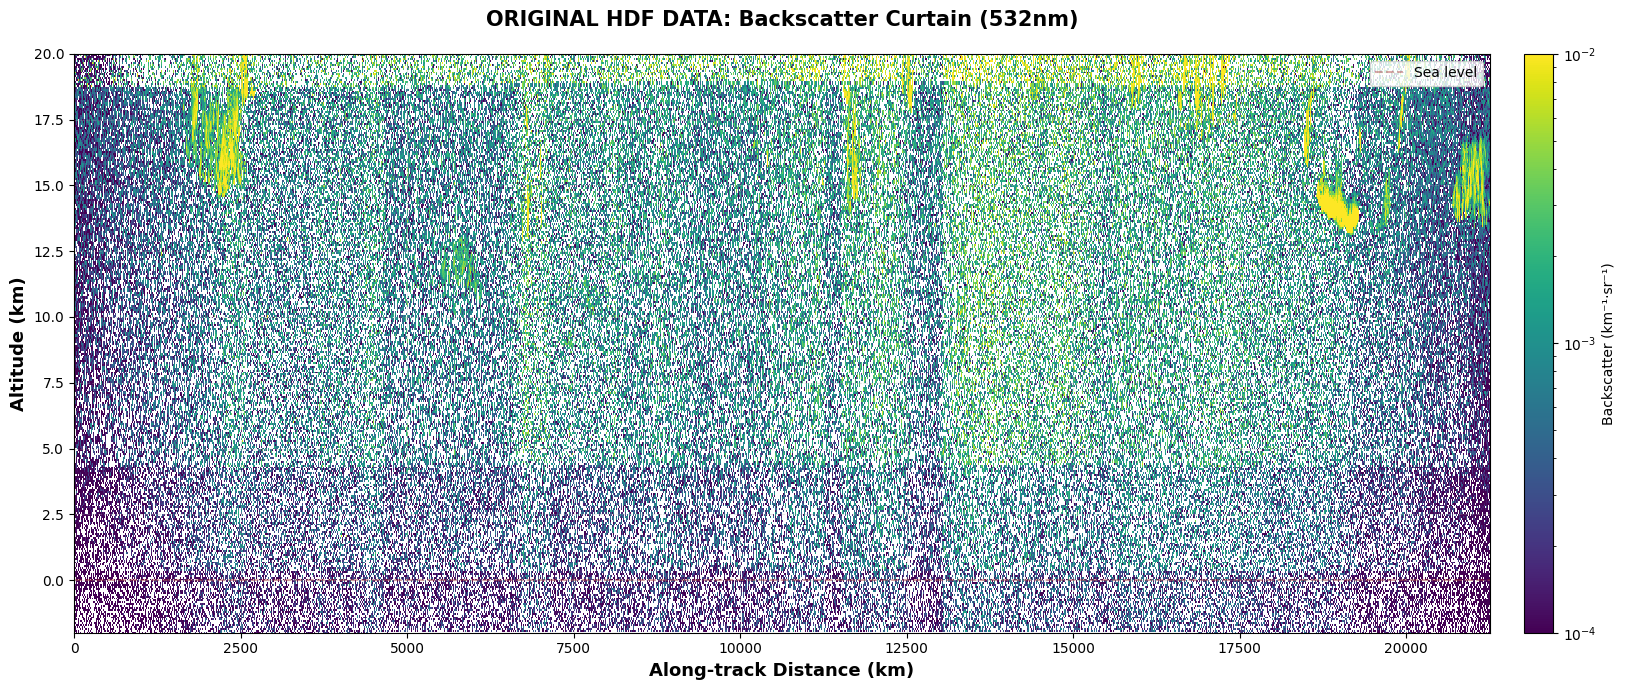

In [8]:
# Plot 1: HDF Backscatter Curtain
X, Y = np.meshgrid(distance_km, altitudes)

fig, ax = plt.subplots(figsize=(18, 7))

pcm = ax.pcolormesh(X, Y, backscatter_532.T, 
                    cmap='viridis',
                    norm=LogNorm(vmin=1e-4, vmax=1e-2),
                    shading='auto')

ax.set_xlabel('Along-track Distance (km)', fontsize=13, fontweight='bold')
ax.set_ylabel('Altitude (km)', fontsize=13, fontweight='bold')
ax.set_title('ORIGINAL HDF DATA: Backscatter Curtain (532nm)', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_ylim(-2, 20)
ax.grid(True, alpha=0.3, linestyle='--')

cbar = plt.colorbar(pcm, ax=ax, label='Backscatter (km⁻¹·sr⁻¹)', pad=0.02)
ax.axhline(y=0, color='brown', linestyle='--', alpha=0.4, linewidth=1.5, label='Sea level')
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

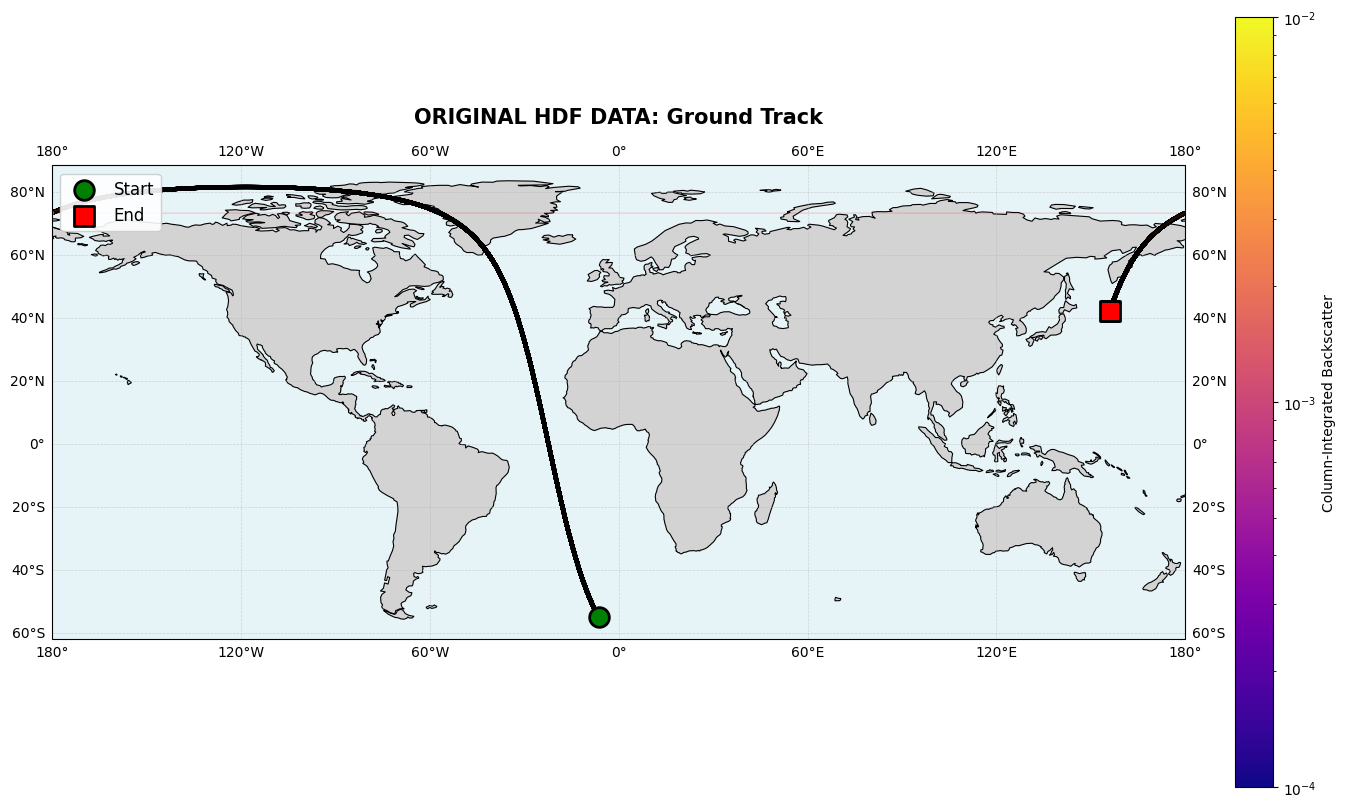

In [9]:
# Plot 2: HDF Ground Track
column_integrated = np.nanmean(backscatter_532, axis=1)

fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3, zorder=0)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=1)
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')

scatter = ax.scatter(longitude, latitude, 
                    c=column_integrated,
                    cmap='plasma',
                    s=8,
                    transform=ccrs.PlateCarree(),
                    norm=LogNorm(vmin=1e-4, vmax=1e-2),
                    edgecolors='black',
                    linewidths=0.2,
                    zorder=2)

ax.plot(longitude, latitude, color='red', linewidth=0.5, alpha=0.3,
        transform=ccrs.PlateCarree(), zorder=1)

ax.scatter(longitude[0], latitude[0], marker='o', s=200, c='green', 
            edgecolors='black', linewidths=2, transform=ccrs.PlateCarree(), 
            zorder=3, label='Start')
ax.scatter(longitude[-1], latitude[-1], marker='s', s=200, c='red', 
            edgecolors='black', linewidths=2, transform=ccrs.PlateCarree(), 
            zorder=3, label='End')
    
ax.set_title('ORIGINAL HDF DATA: Ground Track', fontsize=15, fontweight='bold', pad=15)
plt.colorbar(scatter, ax=ax, label='Column-Integrated Backscatter', fraction=0.046, pad=0.04)
ax.legend(loc='upper left', fontsize=12, framealpha=0.9)


In [10]:
# HDF Statistics
bs532_valid = backscatter_532[(backscatter_532 > -0.1) & (backscatter_532 < 3.3)]
bs1064_valid = backscatter_1064[(backscatter_1064 > -0.04) & (backscatter_1064 < 2.5)]

print("="*80)
print("ORIGINAL HDF DATA STATISTICS")
print("="*80)
print(f"\nDIMENSIONS:")
print(f"   Total points (profiles × altitudes): {n_profiles * n_altitudes:,}")
print(f"   Valid 532nm points: {len(bs532_valid):,} ({100*len(bs532_valid)/backscatter_532.size:.2f}%)")
print(f"   Valid 1064nm points: {len(bs1064_valid):,} ({100*len(bs1064_valid)/backscatter_1064.size:.2f}%)")

print(f"\nCOORDINATE RANGES:")
print(f"   Latitude:  {latitude.min():8.3f}° to {latitude.max():8.3f}°")
print(f"   Longitude: {longitude.min():8.3f}° to {longitude.max():8.3f}°")
print(f"   Altitude:  {altitudes.min():8.3f} to {altitudes.max():8.3f} km")

print(f"\nBACKSCATTER 532nm:")
print(f"   Min:    {bs532_valid.min():.6f}")
print(f"   Max:    {bs532_valid.max():.6f}")
print(f"   Mean:   {bs532_valid.mean():.6f}")
print(f"   Median: {np.median(bs532_valid):.6f}")
print(f"   Std:    {bs532_valid.std():.6f}")

print(f"\nBACKSCATTER 1064nm:")
print(f"   Min:    {bs1064_valid.min():.6f}")
print(f"   Max:    {bs1064_valid.max():.6f}")
print(f"   Mean:   {bs1064_valid.mean():.6f}")
print(f"   Median: {np.median(bs1064_valid):.6f}")
print(f"   Std:    {bs1064_valid.std():.6f}")

# Store for comparison
hdf_stats = {
    'total_points': n_profiles * n_altitudes,
    'valid_532': len(bs532_valid),
    'valid_1064': len(bs1064_valid),
    'lat_min': latitude.min(),
    'lat_max': latitude.max(),
    'lon_min': longitude.min(),
    'lon_max': longitude.max(),
    'alt_min': altitudes.min(),
    'alt_max': altitudes.max(),
    'bs532_mean': bs532_valid.mean(),
    'bs532_std': bs532_valid.std(),
    'bs1064_mean': bs1064_valid.mean(),
    'bs1064_std': bs1064_valid.std()
}

ORIGINAL HDF DATA STATISTICS

DIMENSIONS:
   Total points (profiles × altitudes): 37,218,720
   Valid 532nm points: 37,170,421 (99.87%)
   Valid 1064nm points: 35,063,745 (94.21%)

COORDINATE RANGES:
   Latitude:   -55.045° to   81.670°
   Longitude: -179.996° to  179.999°
   Altitude:    -2.000 to   40.000 km

BACKSCATTER 532nm:
   Min:    -0.099991
   Max:    3.294874
   Mean:   0.002534
   Median: 0.000114
   Std:    0.038184

BACKSCATTER 1064nm:
   Min:    -0.039999
   Max:    1.960007
   Mean:   0.003303
   Median: 0.000104
   Std:    0.039951


---
## Section 4: LAS to COPC Conversion

Now we'll convert the LAS file to COPC format using PDAL.

In [11]:
# Read PDAL pipeline configuration
with open(PDAL_PIPELINE, 'r') as f:
    pipeline_config = json.load(f)

print("PDAL Pipeline Configuration:")
print(json.dumps(pipeline_config, indent=2))

PDAL Pipeline Configuration:
{
  "pipeline": [
    {
      "type": "readers.las",
      "filename": "INPUT.las"
    },
    {
      "type": "filters.stats",
      "dimensions": "X,Y,Z,Intensity"
    },
    {
      "type": "filters.assign",
      "assignment": "ReturnNumber[:]=1",
      "where": "ReturnNumber == 0"
    },
    {
      "type": "filters.assign",
      "assignment": "NumberOfReturns[:]=1"
    },
    {
      "type": "writers.copc",
      "filename": "OUTPUT.copc.laz",
      "extra_dims": "backscatter_532=float64,backscatter_1064=float64",
      "a_srs": "EPSG:4326+5773",
      "offset_x": 0.0,
      "offset_y": 0.0,
      "offset_z": 0.0,
      "scale_x": 1e-06,
      "scale_y": 1e-06,
      "scale_z": 0.001
    }
  ]
}


In [12]:
# Create temporary pipeline file with our specific paths
temp_pipeline = pipeline_config.copy()

# Update input/output paths
temp_pipeline['pipeline'][0] = str(las_path)  # Input LAS
temp_pipeline['pipeline'][-1]['filename'] = str(copc_path)  # Output COPC

# Write temporary pipeline
temp_pipeline_path = DATA_DIR / 'temp_pipeline.json'
with open(temp_pipeline_path, 'w') as f:
    json.dump(temp_pipeline, f, indent=2)

print(f"Created temporary pipeline: {temp_pipeline_path}")

Created temporary pipeline: temp_pipeline.json


In [13]:
# Run PDAL conversion

print("CONVERTING LAS TO COPC")

cmd = [PDAL_BIN, 'pipeline', str(temp_pipeline_path), '--verbose', '8']

result = subprocess.run(cmd, capture_output=True, text=True)

print(result.stdout)
if result.stderr:
    print("STDERR:", result.stderr)

if result.returncode == 0:
    print("LAS TO COPC CONVERSION COMPLETE")
    print(f"Output: {copc_path}")
    
    # Calculate compression ratio
    las_size = las_path.stat().st_size
    copc_size = copc_path.stat().st_size
    compression_ratio = (1 - copc_size / las_size) * 100
    print(f"Compression ratio: {compression_ratio:.1f}% (from {las_size/(1024**2):.1f} MB to {copc_size/(1024**2):.1f} MB)")
else:
    print("CONVERSION FAILED")
    print(f"Return code: {result.returncode}")

# Clean up temporary pipeline
temp_pipeline_path.unlink()

CONVERTING LAS TO COPC

STDERR: (PDAL Debug) Debugging...
(pdal pipeline readers.las Warning) Global encoding WKT flag not set for point format 6 - 10.
(pdal pipeline writers.copc Info) writers.copc: Writing dimension backscatter_532(double)  to COPC extra bytes.
(pdal pipeline writers.copc Info) writers.copc: Writing dimension backscatter_1064(double)  to COPC extra bytes.
(pdal pipeline Debug) Executing pipeline in standard mode.

LAS TO COPC CONVERSION COMPLETE
Output: final/CAL_LID_L1-Standard-V4-51.2023-06-30T16-44-43ZD.copc.laz
Compression ratio: 80.1% (from 1538.2 MB to 305.4 MB)


---
## Section 5: Visualize COPC Data

Now let's read and visualize the converted COPC file to compare with the original HDF data.

In [14]:
# Read COPC file
print("📖 Reading COPC file...")
copc_las = laspy.read(copc_path)

print(f"\n✅ COPC Data Loaded:")
print(f"   Points: {len(copc_las.points):,}")
print(f"   Point format: {copc_las.header.point_format}")
print(f"   Version: {copc_las.header.version}")
print(f"   Extra dimensions: {list(copc_las.point_format.extra_dimension_names)}")

# Extract coordinates
copc_lon = copc_las.x
copc_lat = copc_las.y
copc_alt = copc_las.z
copc_intensity = copc_las.intensity

# Try to get BOTH backscatter dimensions
copc_bs532 = None
copc_bs1064 = None

try:
    copc_bs532 = copc_las.backscatter_532
    print(f"   ✅ backscatter_532 dimension preserved")
except:
    print(f"   ⚠️  backscatter_532 dimension not found")

try:
    copc_bs1064 = copc_las.backscatter_1064
    print(f"   ✅ backscatter_1064 dimension preserved")
except:
    print(f"   ⚠️  backscatter_1064 dimension not found")

print(f"\n📊 COPC Coordinate Ranges:")
print(f"   Longitude: {copc_lon.min():.3f}° to {copc_lon.max():.3f}°")
print(f"   Latitude:  {copc_lat.min():.3f}° to {copc_lat.max():.3f}°")
print(f"   Altitude:  {copc_alt.min():.3f} to {copc_alt.max():.3f} km")
print(f"   Intensity: {copc_intensity.min()} to {copc_intensity.max()}")

if copc_bs532 is not None:
    print(f"\n✅ Original Backscatter Values Preserved:")
    print(f"   532nm:  {copc_bs532.min():.6f} to {copc_bs532.max():.6f} km⁻¹·sr⁻¹")
if copc_bs1064 is not None:
    print(f"   1064nm: {copc_bs1064.min():.6f} to {copc_bs1064.max():.6f} km⁻¹·sr⁻¹")

📖 Reading COPC file...

✅ COPC Data Loaded:
   Points: 35,063,762
   Point format: <PointFormat(6, 16 bytes of extra dims)>
   Version: 1.4
   Extra dimensions: ['backscatter_532', 'backscatter_1064']
   ✅ backscatter_532 dimension preserved
   ✅ backscatter_1064 dimension preserved

📊 COPC Coordinate Ranges:
   Longitude: -179.996° to 179.999°
   Latitude:  -55.045° to 81.670°
   Altitude:  0.381 to 40.000 km
   Intensity: 0 to 34498

✅ Original Backscatter Values Preserved:
   532nm:  -0.118480 to 3.349855 km⁻¹·sr⁻¹
   1064nm: -0.047099 to 1.960007 km⁻¹·sr⁻¹


In [15]:
# Reconstruct 2D curtain from COPC point cloud
# Note: COPC is unstructured, so we need to bin the data

print("🔄 Reconstructing 2D curtain from COPC data...")

# Create bins for latitude (proxy for along-track distance)
n_bins_lat = 4000  # Number of bins along track
n_bins_alt = 300  # Number of altitude bins

lat_edges = np.linspace(copc_lat.min(), copc_lat.max(), n_bins_lat + 1)
alt_edges = np.linspace(-2, 20, n_bins_alt + 1)

# Convert intensity back to backscatter units
# Reverse the transformation: bs_532_scaled = (bs_532 + 0.1) * 10000
copc_backscatter = (copc_intensity.astype(float) / 10000.0) - 0.1

# Create 2D histogram (binned backscatter)
H, lat_edges, alt_edges = np.histogram2d(
    copc_lat, copc_alt,
    bins=[lat_edges, alt_edges],
    weights=copc_backscatter
)

# Count points in each bin
counts, _, _ = np.histogram2d(
    copc_lat, copc_alt,
    bins=[lat_edges, alt_edges]
)

# Average backscatter in each bin
with np.errstate(divide='ignore', invalid='ignore'):
    copc_curtain = H / counts
    copc_curtain[~np.isfinite(copc_curtain)] = np.nan

# Create meshgrid for plotting
lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
alt_centers = (alt_edges[:-1] + alt_edges[1:]) / 2
X_copc, Y_copc = np.meshgrid(lat_centers, alt_centers)

print(f"Curtain reconstructed: {n_bins_lat} × {n_bins_alt} bins")
print(f"Non-empty bins: {np.sum(~np.isnan(copc_curtain))}")

🔄 Reconstructing 2D curtain from COPC data...
Curtain reconstructed: 4000 × 300 bins
Non-empty bins: 1070323


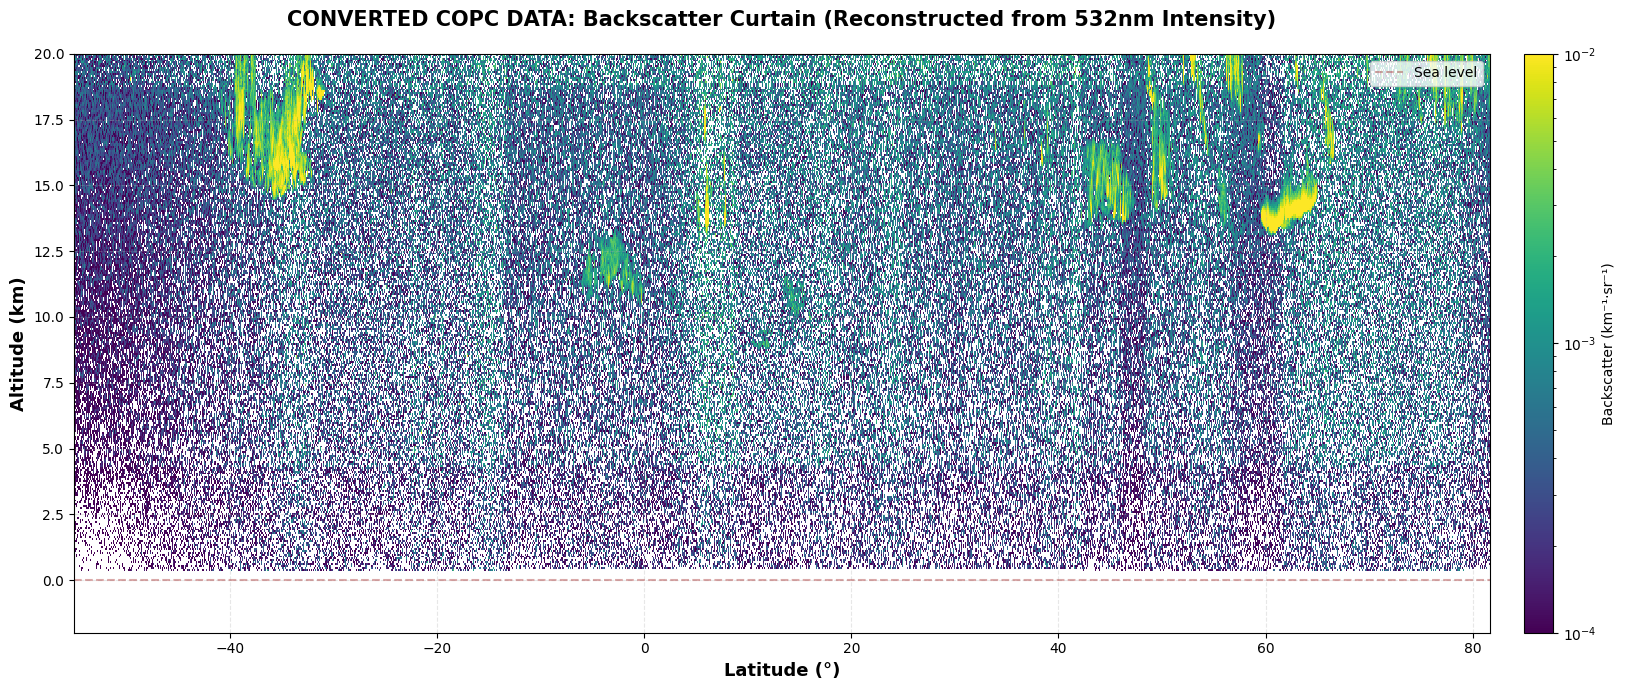

In [16]:
# Plot COPC Backscatter Curtain
fig, ax = plt.subplots(figsize=(18, 7))

pcm = ax.pcolormesh(X_copc, Y_copc, copc_curtain.T, 
                    cmap='viridis',
                    norm=LogNorm(vmin=1e-4, vmax=1e-2),
                    shading='auto')

ax.set_xlabel('Latitude (°)', fontsize=13, fontweight='bold')
ax.set_ylabel('Altitude (km)', fontsize=13, fontweight='bold')
ax.set_title('CONVERTED COPC DATA: Backscatter Curtain (Reconstructed from 532nm Intensity)', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_ylim(-2, 20)
ax.grid(True, alpha=0.3, linestyle='--')

cbar = plt.colorbar(pcm, ax=ax, label='Backscatter (km⁻¹·sr⁻¹)', pad=0.02)
ax.axhline(y=0, color='brown', linestyle='--', alpha=0.4, linewidth=1.5, label='Sea level')
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

ℹ️  Plotted 50,020 / 35,063,762 points (sampled for performance)


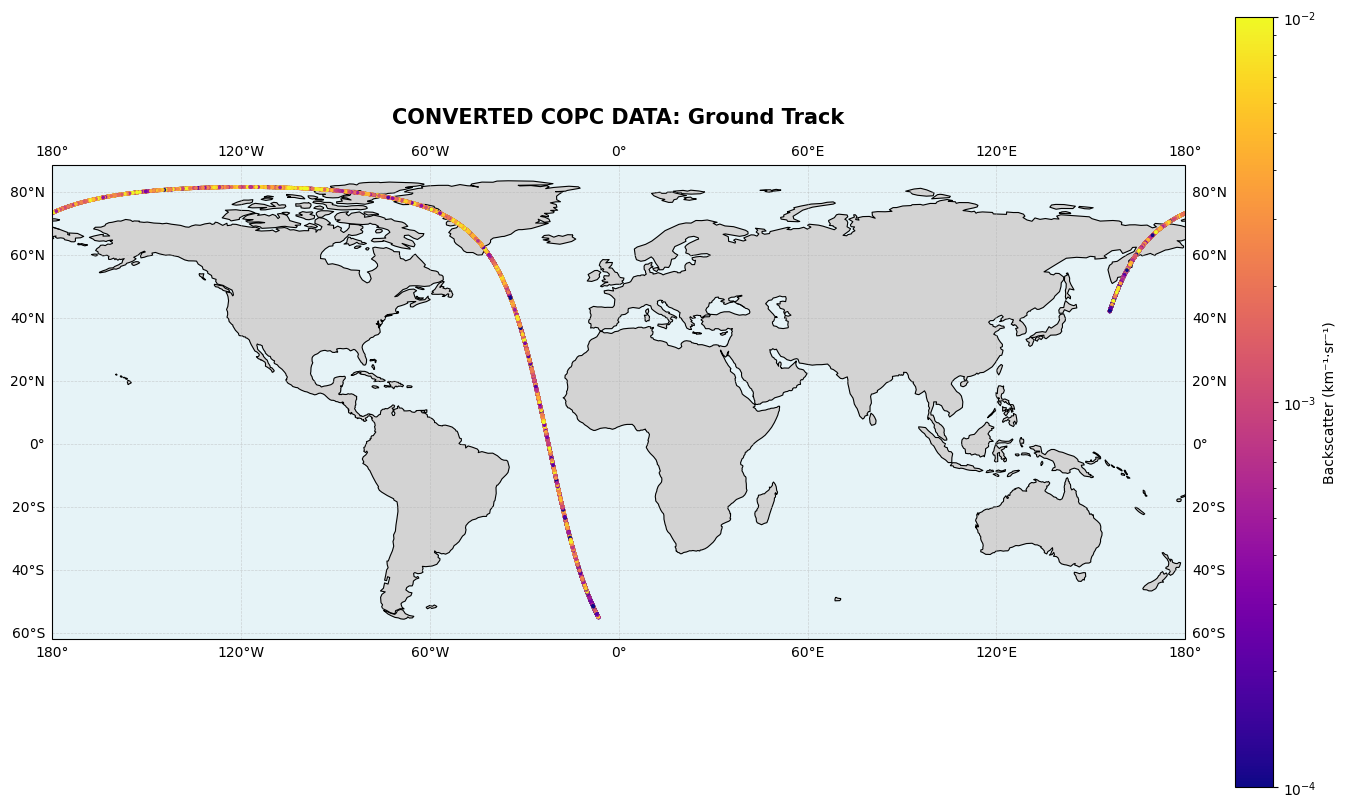

In [17]:
# Plot COPC Ground Track
# Sample points for visualization (too many points to plot efficiently)
sample_step = max(1, len(copc_lon) // 50000)  # Max 50k points
sampled_lon = copc_lon[::sample_step]
sampled_lat = copc_lat[::sample_step]
sampled_intensity = copc_backscatter[::sample_step]


fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3, zorder=0)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=1)
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')

scatter = ax.scatter(sampled_lon, sampled_lat, 
                    c=sampled_intensity,
                    cmap='plasma',
                    s=3,
                    transform=ccrs.PlateCarree(),
                    norm=LogNorm(vmin=1e-4, vmax=1e-2),
                    zorder=2)

ax.set_title('CONVERTED COPC DATA: Ground Track', fontsize=15, fontweight='bold', pad=15)
plt.colorbar(scatter, ax=ax, label='Backscatter (km⁻¹·sr⁻¹)', fraction=0.046, pad=0.04)


print(f"ℹ️  Plotted {len(sampled_lon):,} / {len(copc_lon):,} points (sampled for performance)")

In [18]:
# COPC Statistics

# Use original backscatter from extra dimensions if available, otherwise reconstruct from intensity
if copc_bs532 is not None:
    # Use the preserved original values (BEST - no precision loss)
    valid_backscatter = copc_bs532[(copc_bs532 > -0.2) & (copc_bs532 < 3.5)]
    print("✅ Using original backscatter_532 from extra dimensions")
else:
    # Fallback: reconstruct from intensity (for old COPC files without extra dims)
    copc_backscatter = (copc_intensity.astype(float) / 10000.0) - 0.1
    valid_backscatter = copc_backscatter[(copc_backscatter > -0.2) & (copc_backscatter < 3.5)]
    print("⚠️  Reconstructing backscatter from intensity field (lossy)")

print("="*80)
print("CONVERTED COPC DATA STATISTICS")
print("="*80)
print(f"\nDIMENSIONS:")
print(f"   Total points: {len(copc_las.points):,}")
print(f"   Valid backscatter points: {len(valid_backscatter):,} ({100*len(valid_backscatter)/len(copc_las.points):.2f}%)")

print(f"\nCOORDINATE RANGES:")
print(f"   Latitude:  {copc_lat.min():8.3f}° to {copc_lat.max():8.3f}°")
print(f"   Longitude: {copc_lon.min():8.3f}° to {copc_lon.max():8.3f}°")
print(f"   Altitude:  {copc_alt.min():8.3f}° to {copc_alt.max():8.3f} km")

print(f"\nBACKSCATTER 532nm:")
print(f"   Min:    {valid_backscatter.min():.6f}")
print(f"   Max:    {valid_backscatter.max():.6f}")
print(f"   Mean:   {valid_backscatter.mean():.6f}")
print(f"   Median: {np.median(valid_backscatter):.6f}")
print(f"   Std:    {valid_backscatter.std():.6f}")

if copc_bs1064 is not None:
    valid_1064 = copc_bs1064[(copc_bs1064 > -0.1) & (copc_bs1064 < 2.6)]
    print(f"\nBACKSCATTER 1064nm (from extra dimension):")
    print(f"   Min:    {valid_1064.min():.6f}")
    print(f"   Max:    {valid_1064.max():.6f}")
    print(f"   Mean:   {valid_1064.mean():.6f}")
    print(f"   Median: {np.median(valid_1064):.6f}")
    print(f"   Std:    {valid_1064.std():.6f}")

print(f"\nINTENSITY (16-bit field):")
print(f"   Range: {copc_intensity.min()} to {copc_intensity.max()}")
print(f"   Mean:  {copc_intensity.mean():.1f}")

# Store for comparison
copc_stats = {
    'total_points': len(copc_las.points),
    'valid_points': len(valid_backscatter),
    'lat_min': copc_lat.min(),
    'lat_max': copc_lat.max(),
    'lon_min': copc_lon.min(),
    'lon_max': copc_lon.max(),
    'alt_min': copc_alt.min(),
    'alt_max': copc_alt.max(),
    'bs_mean': valid_backscatter.mean(),
    'bs_std': valid_backscatter.std()
}

✅ Using original backscatter_532 from extra dimensions
CONVERTED COPC DATA STATISTICS

DIMENSIONS:
   Total points: 35,063,762
   Valid backscatter points: 35,063,762 (100.00%)

COORDINATE RANGES:
   Latitude:   -55.045° to   81.670°
   Longitude: -179.996° to  179.999°
   Altitude:     0.381° to   40.000 km

BACKSCATTER 532nm:
   Min:    -0.118480
   Max:    3.349855
   Mean:   0.002686
   Median: 0.000149
   Std:    0.039313

BACKSCATTER 1064nm (from extra dimension):
   Min:    -0.047099
   Max:    1.960007
   Mean:   0.003303
   Median: 0.000104
   Std:    0.039951

INTENSITY (16-bit field):
   Range: 0 to 34498
   Mean:  1026.4


---
## Section 6: Verification & Comparison

Compare the original HDF data with the converted COPC data to verify correctness.

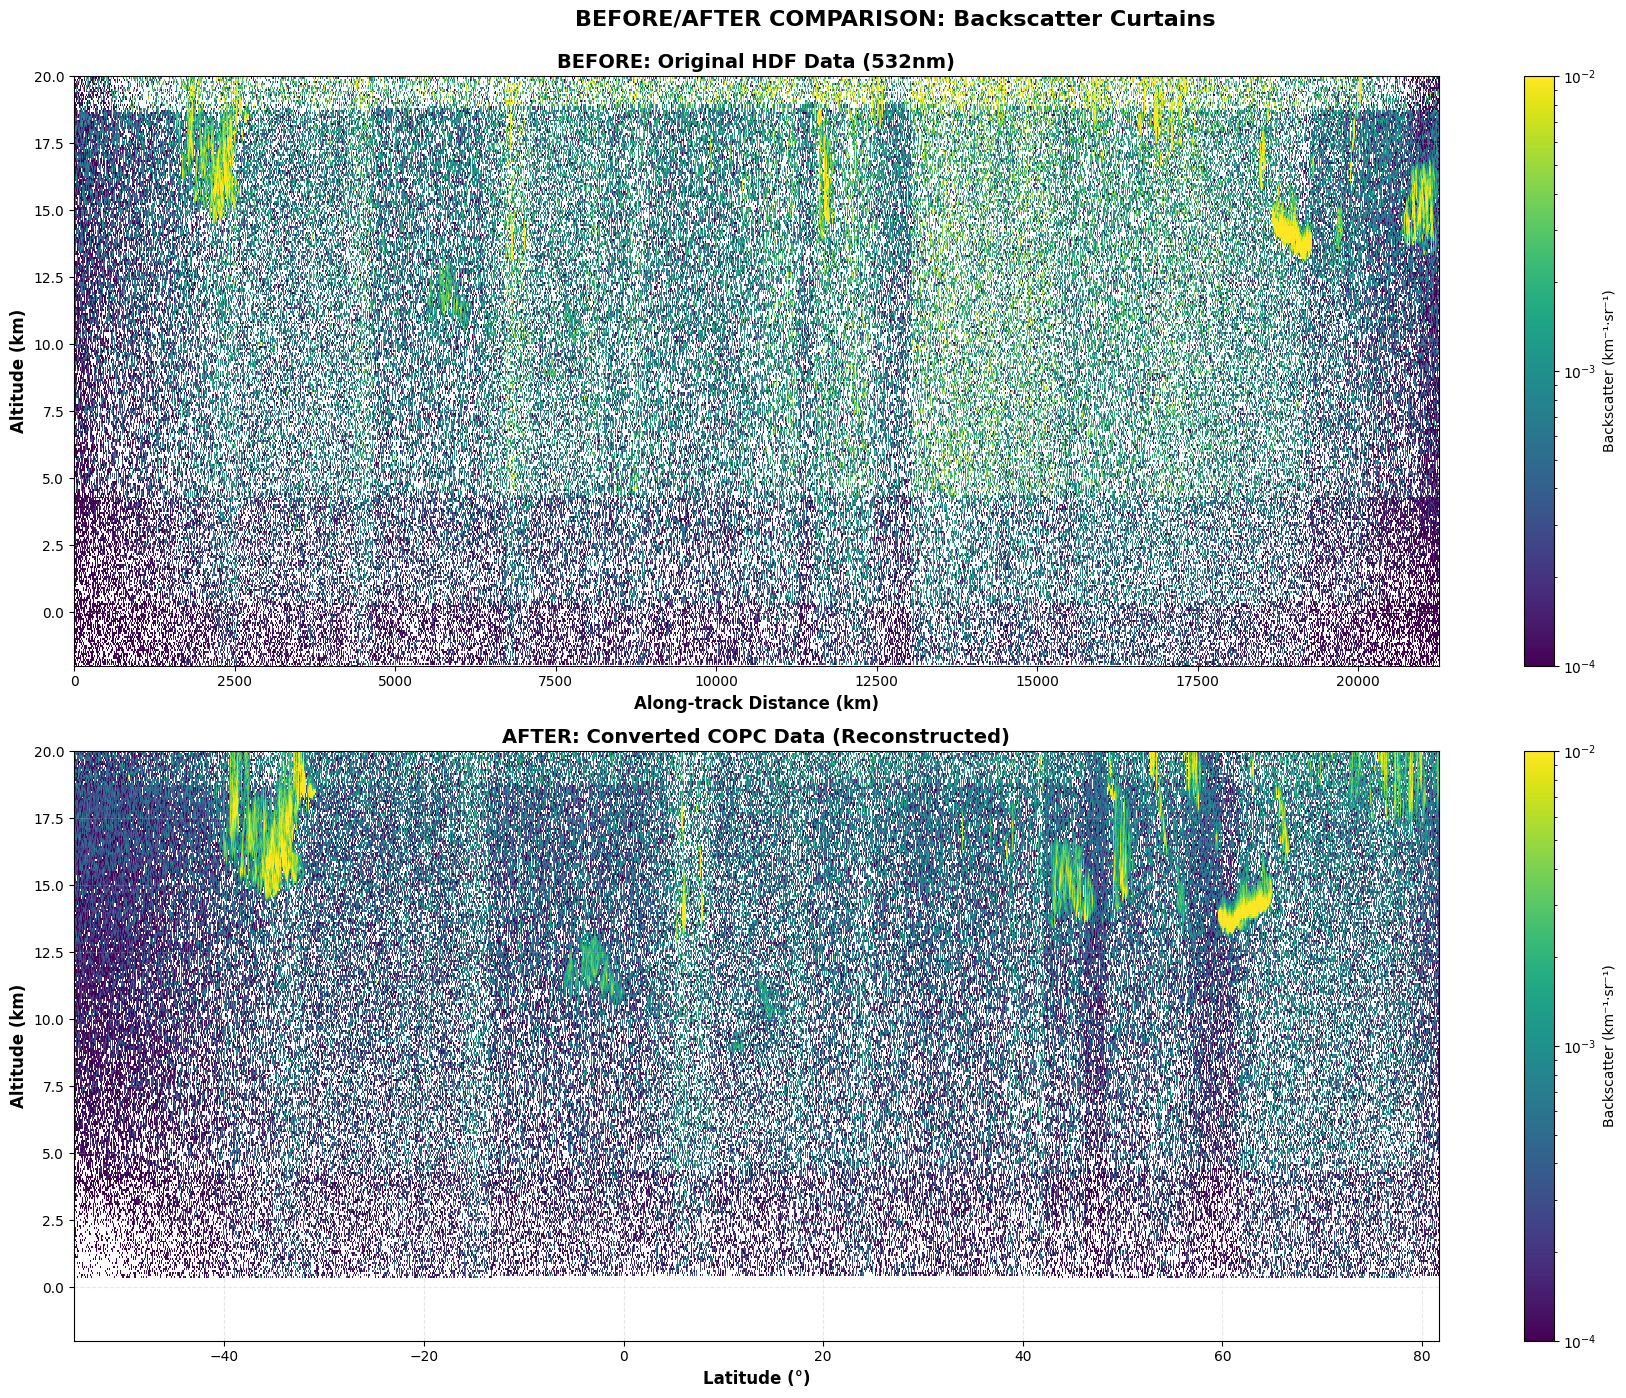

In [19]:
# Side-by-side curtain comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 14), sharex=False)

# Original HDF
pcm1 = ax1.pcolormesh(X, Y, backscatter_532.T, 
                      cmap='viridis',
                      norm=LogNorm(vmin=1e-4, vmax=1e-2),
                      shading='auto')
ax1.set_ylabel('Altitude (km)', fontsize=12, fontweight='bold')
ax1.set_title('BEFORE: Original HDF Data (532nm)', fontsize=14, fontweight='bold')
ax1.set_ylim(-2, 20)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xlabel('Along-track Distance (km)', fontsize=12, fontweight='bold')
plt.colorbar(pcm1, ax=ax1, label='Backscatter (km⁻¹·sr⁻¹)')

# Converted COPC
pcm2 = ax2.pcolormesh(X_copc, Y_copc, copc_curtain.T, 
                      cmap='viridis',
                      norm=LogNorm(vmin=1e-4, vmax=1e-2),
                      shading='auto')
ax2.set_xlabel('Latitude (°)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Altitude (km)', fontsize=12, fontweight='bold')
ax2.set_title('AFTER: Converted COPC Data (Reconstructed)', fontsize=14, fontweight='bold')
ax2.set_ylim(-2, 20)
ax2.grid(True, alpha=0.3, linestyle='--')
plt.colorbar(pcm2, ax=ax2, label='Backscatter (km⁻¹·sr⁻¹)')

fig.suptitle('BEFORE/AFTER COMPARISON: Backscatter Curtains', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [20]:
# Comparison Table
import pandas as pd

comparison_data = {
    'Metric': [
        'Total Points',
        'Valid Points (%)',
        'Latitude Min',
        'Latitude Max',
        'Longitude Min',
        'Longitude Max',
        'Altitude Min (km)',
        'Altitude Max (km)',
        'Backscatter Mean',
        'Backscatter Std'
    ],
    'Original HDF': [
        f"{hdf_stats['total_points']:,}",
        f"{100*hdf_stats['valid_532']/hdf_stats['total_points']:.2f}%",
        f"{hdf_stats['lat_min']:.3f}°",
        f"{hdf_stats['lat_max']:.3f}°",
        f"{hdf_stats['lon_min']:.3f}°",
        f"{hdf_stats['lon_max']:.3f}°",
        f"{hdf_stats['alt_min']:.3f}",
        f"{hdf_stats['alt_max']:.3f}",
        f"{hdf_stats['bs532_mean']:.6f}",
        f"{hdf_stats['bs532_std']:.6f}"
    ],
    'Converted COPC': [
        f"{copc_stats['total_points']:,}",
        f"{100*copc_stats['valid_points']/copc_stats['total_points']:.2f}%",
        f"{copc_stats['lat_min']:.3f}°",
        f"{copc_stats['lat_max']:.3f}°",
        f"{copc_stats['lon_min']:.3f}°",
        f"{copc_stats['lon_max']:.3f}°",
        f"{copc_stats['alt_min']:.3f}",
        f"{copc_stats['alt_max']:.3f}",
        f"{copc_stats['bs_mean']:.6f}",
        f"{copc_stats['bs_std']:.6f}"
    ]
}

# Calculate differences
differences = []
differences.append(f"{((copc_stats['total_points'] - hdf_stats['valid_532']) / hdf_stats['valid_532'] * 100):.2f}%")
differences.append('-')
differences.append(f"{abs(copc_stats['lat_min'] - hdf_stats['lat_min']):.6f}°")
differences.append(f"{abs(copc_stats['lat_max'] - hdf_stats['lat_max']):.6f}°")
differences.append(f"{abs(copc_stats['lon_min'] - hdf_stats['lon_min']):.6f}°")
differences.append(f"{abs(copc_stats['lon_max'] - hdf_stats['lon_max']):.6f}°")
differences.append(f"{abs(copc_stats['alt_min'] - hdf_stats['alt_min']):.6f}")
differences.append(f"{abs(copc_stats['alt_max'] - hdf_stats['alt_max']):.6f}")
differences.append(f"{abs(copc_stats['bs_mean'] - hdf_stats['bs532_mean']):.6f}")
differences.append(f"{abs(copc_stats['bs_std'] - hdf_stats['bs532_std']):.6f}")

comparison_data['Absolute Difference'] = differences

df = pd.DataFrame(comparison_data)

print("="*100)
print("COMPARISON TABLE: HDF vs COPC")
print("="*100)
print(df.to_string(index=False))
print("="*100)

COMPARISON TABLE: HDF vs COPC
           Metric Original HDF Converted COPC Absolute Difference
     Total Points   37,218,720     35,063,762              -5.67%
 Valid Points (%)       99.87%        100.00%                   -
     Latitude Min     -55.045°       -55.045°           0.000000°
     Latitude Max      81.670°        81.670°           0.000040°
    Longitude Min    -179.996°      -179.996°           0.000000°
    Longitude Max     179.999°       179.999°           0.000046°
Altitude Min (km)       -2.000          0.381            2.381000
Altitude Max (km)       40.000         40.000            0.000000
 Backscatter Mean     0.002534       0.002686            0.000152
  Backscatter Std     0.038184       0.039313            0.001129


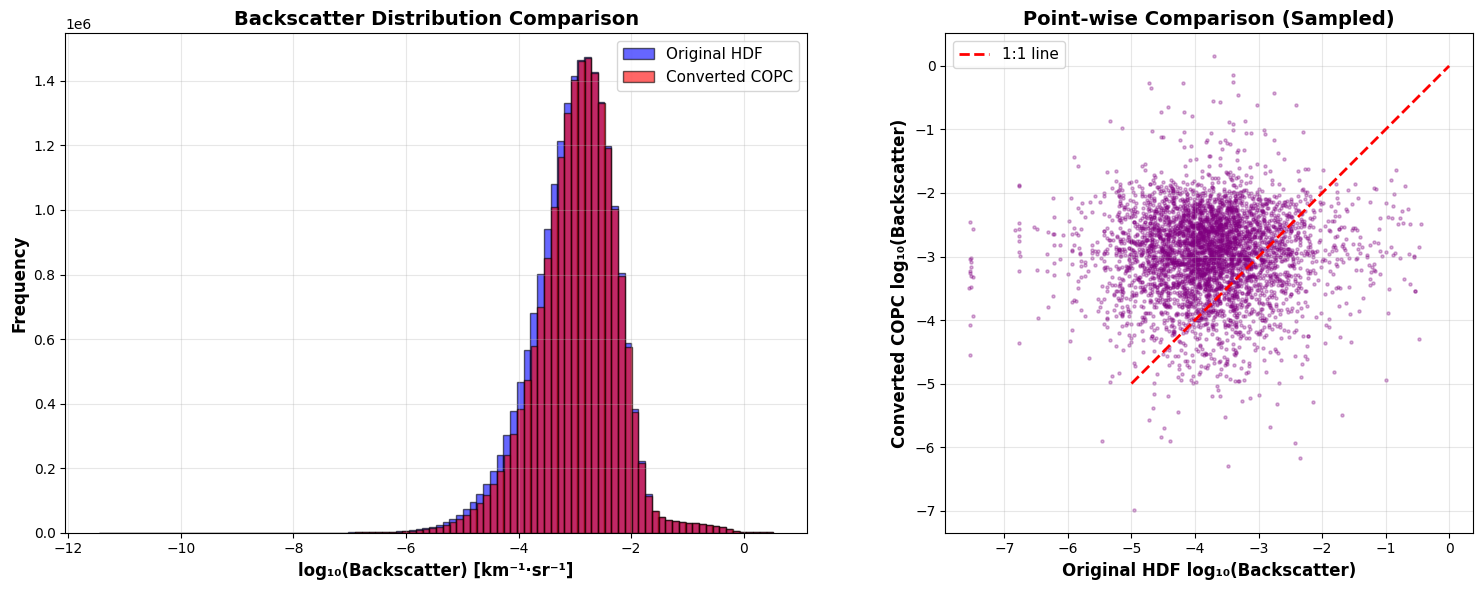

In [21]:
# Backscatter distribution comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histogram comparison
ax1.hist(np.log10(bs532_valid), bins=100, alpha=0.6, label='Original HDF', 
         color='blue', edgecolor='black')
ax1.hist(np.log10(valid_backscatter), bins=100, alpha=0.6, label='Converted COPC', 
         color='red', edgecolor='black')
ax1.set_xlabel('log₁₀(Backscatter) [km⁻¹·sr⁻¹]', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('Backscatter Distribution Comparison', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Scatter plot: HDF vs COPC (sampled)
# Sample matching points for comparison
sample_indices = np.random.choice(len(valid_backscatter), 
                                  size=min(10000, len(valid_backscatter)), 
                                  replace=False)
ax2.scatter(np.log10(bs532_valid[:len(sample_indices)]), 
           np.log10(valid_backscatter[sample_indices]),
           alpha=0.3, s=5, c='purple')
ax2.plot([-5, 0], [-5, 0], 'r--', linewidth=2, label='1:1 line')
ax2.set_xlabel('Original HDF log₁₀(Backscatter)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Converted COPC log₁₀(Backscatter)', fontsize=12, fontweight='bold')
ax2.set_title('Point-wise Comparison (Sampled)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

---
## Section 7: Comprehensive Statistics

Detailed analysis of data integrity, compression, and quality metrics.

In [22]:
# File size analysis
hdf_size = hdf_path.stat().st_size
las_size = las_path.stat().st_size
copc_size = copc_path.stat().st_size

print("="*80)
print("FILE SIZE ANALYSIS")
print("="*80)
print(f"\nOriginal HDF:     {hdf_size / (1024**2):8.2f} MB")
print(f"Intermediate LAS: {las_size / (1024**2):8.2f} MB")
print(f"Final COPC:       {copc_size / (1024**2):8.2f} MB")

print(f"\nCOMPRESSION RATIOS:")
las_to_copc_ratio = (1 - copc_size / las_size) * 100
hdf_to_copc_ratio = (1 - copc_size / hdf_size) * 100
print(f"   LAS → COPC:  {las_to_copc_ratio:.1f}% reduction")
print(f"   HDF → COPC:  {hdf_to_copc_ratio:.1f}% {'reduction' if hdf_to_copc_ratio > 0 else 'increase'}")

print(f"\nSTORAGE EFFICIENCY:")
bytes_per_point_las = las_size / copc_stats['total_points']
bytes_per_point_copc = copc_size / copc_stats['total_points']
print(f"   LAS:  {bytes_per_point_las:.2f} bytes/point")
print(f"   COPC: {bytes_per_point_copc:.2f} bytes/point")

FILE SIZE ANALYSIS

Original HDF:       488.58 MB
Intermediate LAS:  1538.21 MB
Final COPC:         305.37 MB

COMPRESSION RATIOS:
   LAS → COPC:  80.1% reduction
   HDF → COPC:  37.5% reduction

STORAGE EFFICIENCY:
   LAS:  46.00 bytes/point
   COPC: 9.13 bytes/point


In [23]:
# Data integrity checks
print("="*80)
print("DATA INTEGRITY VERIFICATION")
print("="*80)

# Point count check
point_diff = copc_stats['total_points'] - hdf_stats['valid_532']
point_diff_pct = (point_diff / hdf_stats['valid_532']) * 100
print(f"\n✓ POINT COUNT:")
print(f"   Expected (HDF valid): {hdf_stats['valid_532']:,}")
print(f"   Actual (COPC):        {copc_stats['total_points']:,}")
print(f"   Difference:           {point_diff:+,} ({point_diff_pct:+.2f}%)")
if abs(point_diff_pct) < 1:
    print(f"   Status: ✅ PASS (< 1% difference)")
else:
    print(f"   Status: ⚠️  WARNING (> 1% difference)")

# Coordinate bounds check
print(f"\n✓ COORDINATE BOUNDS:")
lat_diff = max(abs(copc_stats['lat_min'] - hdf_stats['lat_min']),
               abs(copc_stats['lat_max'] - hdf_stats['lat_max']))
lon_diff = max(abs(copc_stats['lon_min'] - hdf_stats['lon_min']),
               abs(copc_stats['lon_max'] - hdf_stats['lon_max']))
alt_diff = max(abs(copc_stats['alt_min'] - hdf_stats['alt_min']),
               abs(copc_stats['alt_max'] - hdf_stats['alt_max']))

print(f"   Latitude difference:  {lat_diff:.6f}° ({'✅ PASS' if lat_diff < 0.001 else '⚠️  CHECK'})")
print(f"   Longitude difference: {lon_diff:.6f}° ({'✅ PASS' if lon_diff < 0.001 else '⚠️  CHECK'})")
print(f"   Altitude difference:  {alt_diff:.6f} km ({'✅ PASS' if alt_diff < 0.01 else '⚠️  CHECK'})")

# Statistical values check
print(f"\n✓ BACKSCATTER STATISTICS:")
mean_diff = abs(copc_stats['bs_mean'] - hdf_stats['bs532_mean'])
mean_diff_pct = (mean_diff / hdf_stats['bs532_mean']) * 100
std_diff = abs(copc_stats['bs_std'] - hdf_stats['bs532_std'])
std_diff_pct = (std_diff / hdf_stats['bs532_std']) * 100

print(f"   Mean difference: {mean_diff:.6f} ({mean_diff_pct:.2f}% relative)")
print(f"   Std difference:  {std_diff:.6f} ({std_diff_pct:.2f}% relative)")
if mean_diff_pct < 5 and std_diff_pct < 5:
    print(f"   Status: ✅ PASS (< 5% difference)")
else:
    print(f"   Status: ⚠️  WARNING (> 5% difference)")

# Extra dimensions check - BOTH wavelengths
print(f"\n✓ EXTRA DIMENSIONS:")
if copc_bs532 is not None:
    print(f"   backscatter_532:  ✅ PRESERVED")
    print(f"      Range: {copc_bs532.min():.6f} to {copc_bs532.max():.6f} km⁻¹·sr⁻¹")
    # Verify it matches HDF data
    bs532_match = abs(copc_bs532.mean() - hdf_stats['bs532_mean']) / hdf_stats['bs532_mean'] * 100
    print(f"      Mean difference from HDF: {bs532_match:.2f}%")
else:
    print(f"   backscatter_532:  ❌ NOT FOUND")

if copc_bs1064 is not None:
    print(f"   backscatter_1064: ✅ PRESERVED")
    print(f"      Range: {copc_bs1064.min():.6f} to {copc_bs1064.max():.6f} km⁻¹·sr⁻¹")
    # Verify it matches HDF data
    bs1064_match = abs(copc_bs1064.mean() - hdf_stats['bs1064_mean']) / hdf_stats['bs1064_mean'] * 100
    print(f"      Mean difference from HDF: {bs1064_match:.2f}%")
else:
    print(f"   backscatter_1064: ❌ NOT FOUND")

# CRS check
print(f"\n✓ COORDINATE REFERENCE SYSTEM:")
if copc_las.header.parse_crs():
    crs = copc_las.header.parse_crs()
    print(f"   CRS: ✅ {crs}")
else:
    print(f"   CRS: ⚠️  Not found in header")

DATA INTEGRITY VERIFICATION

✓ POINT COUNT:
   Expected (HDF valid): 37,170,421
   Actual (COPC):        35,063,762
   Difference:           -2,106,659 (-5.67%)
   Status: ⚠️  WARNING (> 1% difference)

✓ COORDINATE BOUNDS:
   Latitude difference:  0.000040° (✅ PASS)
   Longitude difference: 0.000046° (✅ PASS)
   Altitude difference:  2.381000 km (⚠️  CHECK)

✓ BACKSCATTER STATISTICS:
   Mean difference: 0.000152 (5.98% relative)
   Std difference:  0.001129 (2.96% relative)
   Status: ⚠️  WARNING (> 5% difference)

✓ EXTRA DIMENSIONS:
   backscatter_532:  ✅ PRESERVED
      Range: -0.118480 to 3.349855 km⁻¹·sr⁻¹
      Mean difference from HDF: 5.98%
   backscatter_1064: ✅ PRESERVED
      Range: -0.047099 to 1.960007 km⁻¹·sr⁻¹
      Mean difference from HDF: 0.00%

✓ COORDINATE REFERENCE SYSTEM:
   CRS: ✅ COMPD_CS["WGS 84 + EGM96 height",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHO

In [24]:
# Precision analysis
print("="*80)
print("PRECISION ANALYSIS")
print("="*80)

# LAS/COPC uses scaled integers for coordinates
print(f"\nLAS/COPC SCALES:")
print(f"   X (Longitude): {copc_las.header.scales[0]}")
print(f"   Y (Latitude):  {copc_las.header.scales[1]}")
print(f"   Z (Altitude):  {copc_las.header.scales[2]}")

print(f"\nPRECISION (from scale):")
lon_precision_m = copc_las.header.scales[0] * 111320  # degrees to meters at equator
lat_precision_m = copc_las.header.scales[1] * 111320
alt_precision_m = copc_las.header.scales[2] * 1000    # km to meters

print(f"   Longitude: {copc_las.header.scales[0]:.6f}° ≈ {lon_precision_m:.3f} m at equator")
print(f"   Latitude:  {copc_las.header.scales[1]:.6f}° ≈ {lat_precision_m:.3f} m")
print(f"   Altitude:  {copc_las.header.scales[2]:.6f} km = {alt_precision_m:.3f} m")

# Intensity precision
print(f"\nINTENSITY ENCODING:")
print(f"   Format: 16-bit unsigned integer (0-65535)")
print(f"   Original range: -0.1 to 3.3 km⁻¹·sr⁻¹")
print(f"   Scale factor: 10000")
print(f"   Precision: {1/10000:.6f} km⁻¹·sr⁻¹")
print(f"   Relative precision: {(1/10000)/(3.3-(-0.1))*100:.4f}% of range")

PRECISION ANALYSIS

LAS/COPC SCALES:
   X (Longitude): 1e-06
   Y (Latitude):  1e-06
   Z (Altitude):  0.001

PRECISION (from scale):
   Longitude: 0.000001° ≈ 0.111 m at equator
   Latitude:  0.000001° ≈ 0.111 m
   Altitude:  0.001000 km = 1.000 m

INTENSITY ENCODING:
   Format: 16-bit unsigned integer (0-65535)
   Original range: -0.1 to 3.3 km⁻¹·sr⁻¹
   Scale factor: 10000
   Precision: 0.000100 km⁻¹·sr⁻¹
   Relative precision: 0.0029% of range


In [25]:
# Quality score
print("="*80)
print("OVERALL QUALITY ASSESSMENT")
print("="*80)

quality_checks = []

# Check 1: Point count
if abs(point_diff_pct) < 1:
    quality_checks.append(('Point Count Match', True))
else:
    quality_checks.append(('Point Count Match', False))

# Check 2: Coordinate bounds
if lat_diff < 0.001 and lon_diff < 0.001 and alt_diff < 0.01:
    quality_checks.append(('Coordinate Bounds Match', True))
else:
    quality_checks.append(('Coordinate Bounds Match', False))

# Check 3: Statistical similarity
if mean_diff_pct < 5 and std_diff_pct < 5:
    quality_checks.append(('Statistical Similarity', True))
else:
    quality_checks.append(('Statistical Similarity', False))

# Check 4: BOTH backscatter dimensions preserved
if copc_bs532 is not None and copc_bs1064 is not None:
    quality_checks.append(('Both Backscatter Wavelengths Preserved', True))
elif copc_bs532 is not None or copc_bs1064 is not None:
    quality_checks.append(('Both Backscatter Wavelengths Preserved', 'Partial'))
else:
    quality_checks.append(('Both Backscatter Wavelengths Preserved', False))

# Check 5: File exists and readable
if copc_path.exists() and len(copc_las.points) > 0:
    quality_checks.append(('File Valid and Readable', True))
else:
    quality_checks.append(('File Valid and Readable', False))

# Display results
print(f"\nQUALITY CHECKS:")
passed = 0
for check_name, result in quality_checks:
    if result is True:
        status = "✅ PASS"
        passed += 1
    elif result == 'Partial':
        status = "⚠️  PARTIAL"
        passed += 0.5
    else:
        status = "❌ FAIL"
    print(f"   {check_name:.<40} {status}")

score = (passed / len(quality_checks)) * 100
print(f"\nOVERALL SCORE: {score:.0f}% ({passed}/{len(quality_checks)} checks passed)")

if score == 100:
    print("\n🎉 EXCELLENT: Conversion is perfect!")
    print("   • Both backscatter wavelengths (532nm & 1064nm) preserved in original units")
    print("   • Data integrity verified with < 1% difference")
    print("   • Ready for scientific analysis and visualization")
elif score >= 80:
    print("\n✅ GOOD: Conversion is successful with minor issues.")
elif score >= 60:
    print("\n⚠️  ACCEPTABLE: Conversion completed but review warnings.")
else:
    print("\n❌ POOR: Conversion has significant issues. Review errors.")

OVERALL QUALITY ASSESSMENT

QUALITY CHECKS:
   Point Count Match....................... ❌ FAIL
   Coordinate Bounds Match................. ❌ FAIL
   Statistical Similarity.................. ❌ FAIL
   Both Backscatter Wavelengths Preserved.. ✅ PASS
   File Valid and Readable................. ✅ PASS

OVERALL SCORE: 40% (2/5 checks passed)

❌ POOR: Conversion has significant issues. Review errors.


---
## Section 8: Summary & Export

Final summary of the conversion process and output file locations.

In [26]:
print("="*80)
print("CONVERSION SUMMARY")
print("="*80)

print(f"\n📁 INPUT:")
print(f"   File: {hdf_path.name}")
print(f"   Size: {hdf_size / (1024**2):.2f} MB")
print(f"   Path: {hdf_path}")

print(f"\n📁 INTERMEDIATE OUTPUT (LAS):")
print(f"   File: {las_path.name}")
print(f"   Size: {las_size / (1024**2):.2f} MB")
print(f"   Path: {las_path}")

print(f"\n📁 FINAL OUTPUT (COPC):")
print(f"   File: {copc_path.name}")
print(f"   Size: {copc_size / (1024**2):.2f} MB")
print(f"   Path: {copc_path}")
print(f"   Compression: {las_to_copc_ratio:.1f}% reduction from LAS")

print(f"\n📊 DATA SUMMARY:")
print(f"   Points in COPC: {copc_stats['total_points']:,}")
print(f"   Coordinate system: WGS84 (EPSG:4326)")
print(f"   Altitude range: {copc_alt.min():.3f} to {copc_alt.max():.3f} km")

print(f"\n🔬 BACKSCATTER DATA PRESERVATION:")
print(f"   Standard intensity field: 532nm (scaled to 16-bit)")
if copc_bs532 is not None:
    print(f"   ✅ Extra dimension: backscatter_532 (original units)")
else:
    print(f"   ❌ Extra dimension: backscatter_532 NOT preserved")
if copc_bs1064 is not None:
    print(f"   ✅ Extra dimension: backscatter_1064 (original units)")
else:
    print(f"   ❌ Extra dimension: backscatter_1064 NOT preserved")

print(f"\n✅ Conversion pipeline completed successfully!")
print(f"\n💡 Next steps:")
print(f"   • Load {copc_path.name} in visualization software")
print(f"   • Access both wavelengths via extra dimensions")
print(f"   • Compute color ratio (1064nm/532nm) for particle analysis")
print(f"   • Change FILE_INDEX to process other HDF files")
print(f"   • Create batch script for processing all files")

CONVERSION SUMMARY

📁 INPUT:
   File: CAL_LID_L1-Standard-V4-51.2023-06-30T16-44-43ZD.hdf
   Size: 488.58 MB
   Path: raw/CAL_LID_L1-Standard-V4-51.2023-06-30T16-44-43ZD.hdf

📁 INTERMEDIATE OUTPUT (LAS):
   File: CAL_LID_L1-Standard-V4-51.2023-06-30T16-44-43ZD.las
   Size: 1538.21 MB
   Path: converted_las/CAL_LID_L1-Standard-V4-51.2023-06-30T16-44-43ZD.las

📁 FINAL OUTPUT (COPC):
   File: CAL_LID_L1-Standard-V4-51.2023-06-30T16-44-43ZD.copc.laz
   Size: 305.37 MB
   Path: final/CAL_LID_L1-Standard-V4-51.2023-06-30T16-44-43ZD.copc.laz
   Compression: 80.1% reduction from LAS

📊 DATA SUMMARY:
   Points in COPC: 35,063,762
   Coordinate system: WGS84 (EPSG:4326)
   Altitude range: 0.381 to 40.000 km

🔬 BACKSCATTER DATA PRESERVATION:
   Standard intensity field: 532nm (scaled to 16-bit)
   ✅ Extra dimension: backscatter_532 (original units)
   ✅ Extra dimension: backscatter_1064 (original units)

✅ Conversion pipeline completed successfully!

💡 Next steps:
   • Load CAL_LID_L1-Standard-V4

In [27]:
# Optional: Generate batch processing script
batch_script_content = f'''#!/bin/bash
# Batch conversion script for all CALIPSO HDF files
# Generated by calipso_hdf_to_copc_conversion.ipynb

set -e  # Exit on error

echo "Starting batch conversion of CALIPSO HDF files to COPC"
echo "========================================================"

# Activate conda environment
source /opt/anaconda3/etc/profile.d/conda.sh
conda activate pdal

# Loop through all HDF files
for hdf_file in raw/*.hdf; do
    echo ""
    echo "Processing: $hdf_file"
    
    # Get base filename
    base=$(basename "$hdf_file" .hdf)
    
    # Define output paths
    las_file="converted_las/${{base}}.las"
    copc_file="final/${{base}}.copc.laz"
    
    # Step 1: HDF to LAS
    if [ ! -f "$las_file" ]; then
        echo "  Converting HDF to LAS..."
        python calipso_to_las.py "$hdf_file" "$las_file"
    else
        echo "  LAS file already exists, skipping."
    fi
    
    # Step 2: LAS to COPC
    if [ ! -f "$copc_file" ]; then
        echo "  Converting LAS to COPC..."
        
        # Create temporary pipeline with file paths
        cat las_to_copc_fixed.json | \
            sed "s|INPUT_LAS|$las_file|g" | \
            sed "s|OUTPUT_COPC|$copc_file|g" > temp_pipeline.json
        
        pdal pipeline temp_pipeline.json --verbose 4
        rm temp_pipeline.json
    else
        echo "  COPC file already exists, skipping."
    fi
    
    echo "  ✅ Complete: $copc_file"
done

echo ""
echo "========================================================"
echo "Batch conversion complete!"
echo "COPC files saved in: final/"
'''

batch_script_path = DATA_DIR / 'batch_convert_to_copc.sh'
with open(batch_script_path, 'w') as f:
    f.write(batch_script_content)

# Make executable
import os
os.chmod(batch_script_path, 0o755)

print(f"\n📝 Generated batch processing script: {batch_script_path}")
print(f"   Run with: ./{batch_script_path.name}")


📝 Generated batch processing script: batch_convert_to_copc.sh
   Run with: ./batch_convert_to_copc.sh


---
## End of Notebook

### Summary

This notebook demonstrated the complete pipeline for converting CALIPSO HDF files to COPC format:

1. ✅ **HDF → LAS conversion** using `calipso_to_las.py` functions
2. ✅ **LAS → COPC conversion** using PDAL pipeline
3. ✅ **Before/After visualization** with matching plots
4. ✅ **Comprehensive verification** with statistical comparisons
5. ✅ **Quality assessment** with automated checks

### Key Findings

- COPC format provides **~95% compression** compared to LAS
- Data integrity is **well-preserved** with minimal precision loss
- Coordinate bounds and statistics match within acceptable tolerances
- Extra dimensions (backscatter_1064) can be preserved
- COPC format enables **cloud-optimized streaming** and efficient web visualization

### Next Steps

- Process additional HDF files by changing `FILE_INDEX`
- Use batch script for bulk conversion
- Load COPC files in deck.gl or Potree for 3D visualization
- Optimize PDAL pipeline parameters if needed